In [1]:
from XRDXRFutils import DataXRD, DatabaseXRD, SpectraXRD, FastSpectraXRD, GaussNewton

from numpy import (array, ones, sqrt, full_like)

from matplotlib.pyplot import (figure, subplots, sca, plot, show, close)
from matplotlib import rcParams


#path_shared = '/home/shared/'
path_shared = '../../shared/'

list_path_database = [path_shared + 'Database/']   # tabulated phases

rcParams['font.size'] = 18

# Read phase database

In [2]:
print('Reading phases from: ' + ', '.join(["'" + path + "'" for path in list_path_database]))
database = DatabaseXRD()
for path_database in list_path_database:
    database.read_cifs(path_database)
print(f'Total number of phases: {len(database)}')

Reading phases from: '../../shared/Database/'
Total number of phases: 369


# Build synthetic XRD pattern

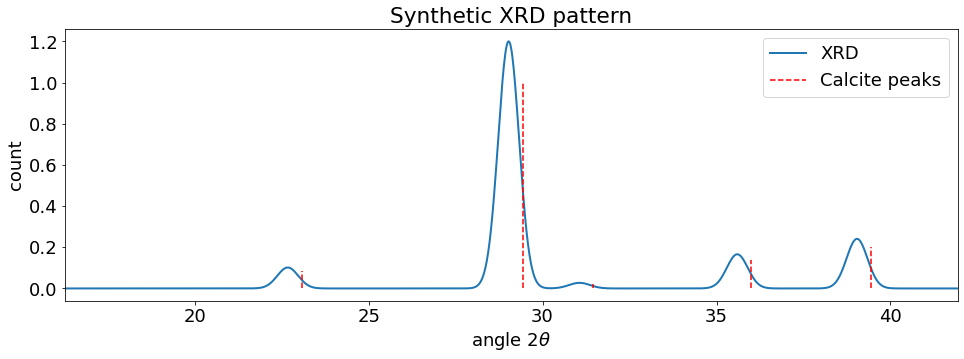

In [3]:
# Choose parameters to build the XRD pattern
min_theta = 16
max_theta = 42
min_intensity = None
first_n_peaks = None

gamma_experimental = 1.2   # rescale peak heights with respect to tabulated ones
sigma_experimental = 0.3   # choose width of the peaks
shift_angle = -0.4         # shift pattern with respect to tabulated angles

###

n_channels = 1280
phase_chosen = database['Calcite'][0]
calibration_right = array([-741.96144778, 2803.29875555, 31.09111973])
gn_dummy = GaussNewton(phase_chosen, SpectraXRD().from_array(ones(n_channels)).calibrate_from_parameters(calibration_right),
    sigma = sigma_experimental, min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
gn_dummy.mu += shift_angle
counts = gn_dummy.z()

spectrum_built = (
    FastSpectraXRD()
    .from_array(counts)
    .calibrate_from_parameters(calibration_right)
    .calculate_downsampled_intensity(gamma_experimental * counts / counts.max())
)

fig, ax = subplots(figsize = (16, 5))
sca(ax)
spectrum_built.plot(lw = 2, label = 'XRD')
phase_chosen.plot(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks, label = phase_chosen.label + ' peaks')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(*spectrum_built.theta_range())
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('count')
ax.set_title('Synthetic XRD pattern')
show()

# Gauss-Newton

### Create

In [8]:
gn = GaussNewton(phase_chosen, spectrum_built, min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
opt_initial = gn.opt.copy()

### View

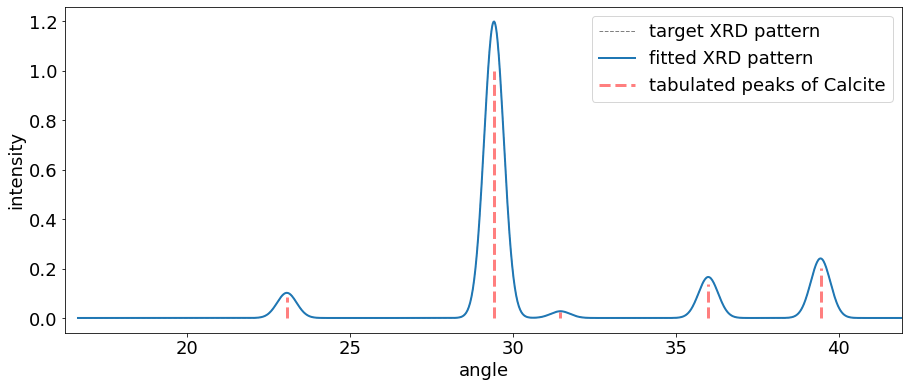

Fit error = 2.5040806459941075e-05
Initial calibration parameters =	[-741.96144778 2803.29875555   31.09111973]
Fitted calibration parameters =	[-741.96144778 2803.29875555   31.49111973]
gamma =	[[1.2 1.2 1.2 1.2 1.2]]
tau =	[[0.3 0.3 0.3 0.3 0.3]]
sigma2 =	[[0.09 0.09 0.09 0.09 0.09]]
sigma =	[[0.3 0.3 0.3 0.3 0.3]]


In [15]:
fig, ax = subplots(figsize = (15, 6))
ax.plot(gn.theta, gn.intensity, ls = '--', lw = 1, c = 'grey', label = 'target XRD pattern')
ax.plot(gn.theta, gn.z(), ls = '-', lw = 2, c = 'tab:blue', label = 'fitted XRD pattern')
ax.vlines(gn.mu, 0, gn.I, 'r', alpha = 0.5, ls = '--', lw = 3, label = 'tabulated peaks of ' + phase_chosen['_chemical_name_mineral'])
ax.set_xlabel('angle')
ax.set_ylabel('intensity')
ax.legend()
ax.set_xlim(*spectrum_built.theta_range())
show()

print(f'Fit error = {sqrt(gn.MSEloss())}')
print(f'Initial calibration parameters =\t{opt_initial}')
print(f'Fitted calibration parameters =\t{gn.opt}')
print(f'gamma =\t{gn.gamma}')
print(f'tau =\t{gn.tau}')
print(f'sigma2 =\t{gn.sigma2}')
print(f'sigma =\t{sqrt(gn.sigma2)}')

### Fit

In [6]:
#gn.fit(a = True, s = True, beta = True)   # adjust calibration
#gn.fit(sigma = True)   # adjust peak width
#gn.fit(gamma = True)   # adjust peak heights
gn.fit(a = True, s = True, beta = True, gamma = True, sigma = True)   # adjust everything

In [6]:
gn.fit_cycle(steps = 16, a = True, s = True, gamma = True, sigma = True)

### Modify

In [10]:
# Set right calibration
gn.opt = calibration_right + array([0, 0, -shift_angle])

In [12]:
# Set right gamma
gn.g = full_like(gn.g, GaussNewton.iw(gamma_experimental))

In [14]:
# Set right sigma
gn.tau = full_like(gn.tau, sigma_experimental)